# Assignment 3: Gesture Recognition 

In this notebook we build gesture recognition models on the **Jester** dataset. All data is stored under the local 'data/' directory.

### 1. Setup and Configuration

We focus on **good performance under compute constraint**. Thereby,
- All models must be trainable **within ~2 hours on a single GPU**.
- We use the provided **20% training subset** for most experiments and hyperparameter tuning.
- Final evaluation is always done on the **full validation set**.

This constraint influences our design choices as we prefer **lightweight architectures** and **simple temporal modelling** over heavier 3D CNNs.

In [34]:
# imports
import os
from pathlib import Path
import random
import time

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix

In [35]:
# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# device config
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    # for Apple Silicon / Mac
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# paths
PROJECT_ROOT = Path(".").resolve()
DATA_ROOT = PROJECT_ROOT / "csv"

TRAIN_CSV = DATA_ROOT / "jester-v1-small-train.csv"
FULL_TRAIN_CSV = DATA_ROOT / "jester-v1-train.csv"
VAL_CSV = DATA_ROOT / "jester-v1-validation.csv"
LABELS_CSV = DATA_ROOT / "jester-v1-labels.csv"

VIDEOS_ROOT = PROJECT_ROOT / "small-20bn-jester-v1"

CONFIG = {
    "seed": 42,
    "device": device,
    "data_root": DATA_ROOT,
    "videos_root": VIDEOS_ROOT,
    "train_csv": TRAIN_CSV,
    "full_train_csv": FULL_TRAIN_CSV,
    "val_csv": VAL_CSV,
    "labels_csv": LABELS_CSV,
    "batch_size": 64,
    "num_workers": 4,
    "num_epochs_baseline": 15,
    "num_epochs_improved": 15,
    "learning_rate": 1e-3,
}

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)
print("Train CSV:", CONFIG["train_csv"])
print("Val CSV:", CONFIG["val_csv"])
print("Labels CSV:", CONFIG["labels_csv"])

# sanity checks
for p in [DATA_ROOT, TRAIN_CSV, VAL_CSV, LABELS_CSV]:
    print(f"{p} exists:", p.exists())

Project root: C:\Users\pavel\OneDrive\Desktop\CV_Assignment3
Data root: C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv
Train CSV: C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv\jester-v1-small-train.csv
Val CSV: C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv\jester-v1-validation.csv
Labels CSV: C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv\jester-v1-labels.csv
C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv exists: True
C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv\jester-v1-small-train.csv exists: True
C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv\jester-v1-validation.csv exists: True
C:\Users\pavel\OneDrive\Desktop\CV_Assignment3\csv\jester-v1-labels.csv exists: True


### Dataset and Data Loading

We use the **Jester** hand-gesture dataset.
- `jester-v1-labels.csv` – list of all 27 gesture labels.
- `jester-v1-small-train.csv` – 20% training subset (id + label per video).
- `jester-v1-train.csv` – full training set (optional, for later experiments).
- `jester-v1-validation.csv` – validation set.

For the baseline model we will treat videos as single images and sample **one frame per clip**. For the imrpoved model, we will extend this to multiple frames per clip to include temporal information.

### 2.1 Parse CSVs, label mapping, Dataset + DataLoader

In [36]:
# 2.1. helper: parse Jester CSVs
def load_jester_split(csv_path: Path) -> pd.DataFrame:
    """This function splits csv into two columns: video_id (str) and label (str)."""
    df_raw = pd.read_csv(csv_path, header=None, names=["raw"])
    split = df_raw["raw"].str.split(";", n=1, expand=True)
    df = pd.DataFrame({
        "video_id": split[0].astype(str),
        "label": split[1].astype(str),
    })
    return df


labels_df = pd.read_csv(CONFIG["labels_csv"], header=None, names=["label"])
gesture_labels = labels_df["label"].tolist()

label_to_idx = {lbl: i for i, lbl in enumerate(gesture_labels)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

print(f"Loaded {len(gesture_labels)} gesture labels.")
print(gesture_labels[:5], "...")

train_df = load_jester_split(CONFIG["train_csv"])
val_df = load_jester_split(CONFIG["val_csv"])

print(f"Train subset size: {len(train_df)}")
print(f"Validation size:   {len(val_df)}")

train_df.head()

Loaded 27 gesture labels.
['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Pushing Hand Away'] ...
Train subset size: 23712
Validation size:   14787


,video_id,label
0,105128,Thumb Up
1,21610,Pushing Hand Away
2,138719,Thumb Up
3,43350,Zooming In With Full Hand
4,28142,Swiping Up


### 2.2. Jester dataset (single frame)

In [37]:
class JesterDatasetSingleFrame(Dataset):
    def __init__(self, df: pd.DataFrame, videos_root: Path,
                 label_to_idx: dict,
                 transform=None,
                 frame_sampling: str = "middle"):
        self.df = df.reset_index(drop=True)
        self.videos_root = Path(videos_root)
        self.label_to_idx = label_to_idx
        self.transform = transform
        assert frame_sampling in ["middle", "random"]
        self.frame_sampling = frame_sampling

        # cache frame paths per video
        self.frame_cache = {}
        unique_ids = self.df["video_id"].unique()
        print(f"Building frame cache for {len(unique_ids)} videos...")
        for vid in unique_ids:
            video_dir = self.videos_root / vid
            frames = sorted(
                f for f in video_dir.iterdir()
                if f.suffix.lower() in [".jpg", ".jpeg", ".png"]
            )
            if not frames:
                raise FileNotFoundError(f"No frame images in {video_dir}")
            self.frame_cache[vid] = frames
        print("Frame cache built.")

    def __len__(self):
        return len(self.df)

    def _select_frame(self, frame_paths):
        if self.frame_sampling == "middle":
            idx = len(frame_paths) // 2
        else:
            idx = torch.randint(low=0, high=len(frame_paths), size=(1,)).item()
        return frame_paths[idx]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = row["video_id"]
        label_str = row["label"]

        frame_paths = self.frame_cache[video_id]
        frame_path = self._select_frame(frame_paths)

        img = Image.open(frame_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        label_idx = self.label_to_idx[label_str]
        return img, label_idx


### 2.3. Transforms and DataLoaders

In [38]:
# std ImageNet-style transforms
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomResizedCrop(112),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_dataset = JesterDatasetSingleFrame(
    df=train_df,
    videos_root=CONFIG["videos_root"],
    label_to_idx=label_to_idx,
    transform=train_transform,
    frame_sampling="middle",
)

val_dataset = JesterDatasetSingleFrame(
    df=val_df,
    videos_root=CONFIG["videos_root"],
    label_to_idx=label_to_idx,
    transform=val_transform,
    frame_sampling="middle",
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    # num_workers=CONFIG["num_workers"],
    num_workers=0,
    pin_memory=(CONFIG["device"].type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    # num_workers=CONFIG["num_workers"],
    num_workers=0,
    pin_memory=(CONFIG["device"].type == "cuda"),
)

len(train_dataset), len(val_dataset)

Building frame cache for 23712 videos...
Frame cache built.
Building frame cache for 14787 videos...
Frame cache built.


(23712, 14787)

### 3. Baseline Model (Single-Frame CNN)

As a baseline, we treat each video as a **single RGB frame**, while also ignorign tempral information. 
We use a **ResNet-18** backbone pretrained on ImageNet and replace its final layer with a 27-way linear head for the gesture classes.

This baseine is lightweight and trains fast, fitting our constraint. Later, we're going to add temporal information on top of this setup.

### 3.1. Model definition

In [39]:
device = CONFIG["device"]

def create_baseline_model(num_classes: int) -> nn.Module:
    """ResNet-18 backbone pretrained on ImageNet."""
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    except AttributeError:
        model = models.resnet18(pretrained=True)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)


num_classes = len(gesture_labels)
baseline_model = create_baseline_model(num_classes)
print(baseline_model.fc)
print("Baseline model on device:", next(baseline_model.parameters()).device)

Linear(in_features=512, out_features=27, bias=True)
Baseline model on device: cuda:0


### 3.2. Training and evaluation

In [40]:
def train_one_epoch(model, loader, criterion, optimizer, device,
                    epoch: int = None, num_epochs: int = None,
                    print_every: int = 50):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    num_batches = len(loader)
    if epoch is not None and num_epochs is not None:
        print(f"Starting epoch {epoch}/{num_epochs} with {num_batches} batches.")
    else:
        print(f"Starting epoch with {num_batches} batches.")

    for batch_idx, (images, labels) in enumerate(loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        # progress print
        if (batch_idx + 1) % print_every == 0 or (batch_idx + 1) == num_batches:
            progress = 100.0 * (batch_idx + 1) / num_batches
            if epoch is not None and num_epochs is not None:
                prefix = f"Epoch [{epoch:02d}/{num_epochs}] "
            else:
                prefix = ""
            print(
                f"\r{prefix}batch {batch_idx + 1}/{num_batches} "
                f"({progress:5.1f}%)", end=""
            )

    if num_batches > 0:
        print()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

### 3.3. Train model

In [41]:
# check batch speed
print(f"Using device for timing: {device}")

start = time.time()
images, labels = next(iter(train_loader))
print("One batch time:", time.time() - start, "seconds")
print("Batch shape:", images.shape)
print("len(train_loader) =", len(train_loader))

Using device for timing: cuda
One batch time: 0.15008926391601562 seconds
Batch shape: torch.Size([64, 3, 112, 112])
len(train_loader) = 371


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=CONFIG["learning_rate"])

num_epochs = CONFIG["num_epochs_baseline"]

history_baseline = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(
        baseline_model,
        train_loader,
        criterion,
        optimizer,
        device,
        epoch=epoch,
        num_epochs=num_epochs,
        print_every=50,
    )

    val_loss, val_acc = evaluate(
        baseline_model, val_loader, criterion, device
    )

    history_baseline["train_loss"].append(train_loss)
    history_baseline["val_loss"].append(val_loss)
    history_baseline["train_acc"].append(train_acc)
    history_baseline["val_acc"].append(val_acc)

    elapsed = time.time() - start_time
    print(
        f"Epoch [{epoch:02d}/{num_epochs}] "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
        f"time: {elapsed:.1f}s"
    )

print("Baseline training finished.")

Starting epoch 1/15 with 371 batches.
Epoch [01/15] batch 371/371 (100.0%)
Epoch [01/15] Train loss: 3.1147, acc: 0.1164 | Val loss: 3.1219, acc: 0.1860 | time: 120.0s
Starting epoch 2/15 with 371 batches.
Epoch [02/15] batch 371/371 (100.0%)
Epoch [02/15] Train loss: 2.7336, acc: 0.2031 | Val loss: 2.2794, acc: 0.3236 | time: 90.3s
Starting epoch 3/15 with 371 batches.
Epoch [03/15] batch 371/371 (100.0%)
Epoch [03/15] Train loss: 2.5486, acc: 0.2473 | Val loss: 2.0836, acc: 0.3612 | time: 88.5s
Starting epoch 4/15 with 371 batches.
Epoch [04/15] batch 371/371 (100.0%)
Epoch [04/15] Train loss: 2.4402, acc: 0.2742 | Val loss: 2.0015, acc: 0.3875 | time: 111.7s
Starting epoch 5/15 with 371 batches.
Epoch [05/15] batch 371/371 (100.0%)
Epoch [05/15] Train loss: 2.3559, acc: 0.2957 | Val loss: 1.8666, acc: 0.4096 | time: 134.0s
Starting epoch 6/15 with 371 batches.
Epoch [06/15] batch 371/371 (100.0%)
Epoch [06/15] Train loss: 2.2995, acc: 0.3096 | Val loss: 1.8645, acc: 0.4137 | time: 1

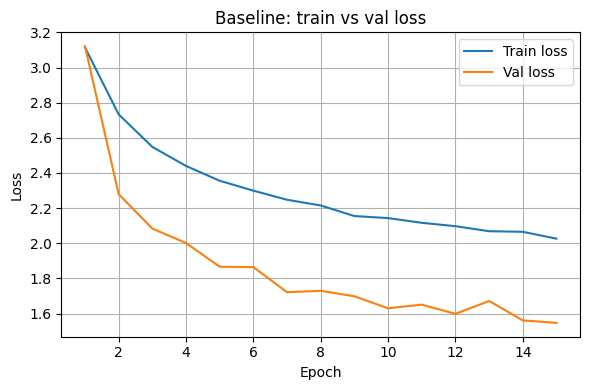

<Figure size 640x480 with 0 Axes>

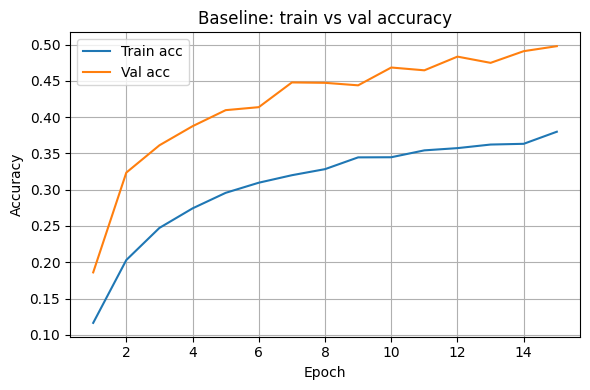

<Figure size 640x480 with 0 Axes>

In [43]:
epochs = range(1, num_epochs + 1)

# loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_baseline["train_loss"], label="Train loss")
plt.plot(epochs, history_baseline["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline: train vs val loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("baseline_loss_curve.png", dpi=300)

# accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_baseline["train_acc"], label="Train acc")
plt.plot(epochs, history_baseline["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline: train vs val accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("baseline_acc_curve.png", dpi=300)

### 4. Improved Model (Temporal Modeling)

To step up from the baseline model, we incorporate temporal information and shift to operating on **mutliple frames per video**. To do so, we sample a fixed number of frames across the video. Each frame is processed by the same ResNet-18backbone, and we **average the frame-wise features over time** before the final classification layer.

While keeping the backbone lightweight, we still allow the model to exploit motion and gesture dynamics instead of relying on static frames. We exect compute per batc to increase linearly with the number of frames, so we use a smaller batch size to remain within the constraint.

### 4.1. Multi-frame dataset

In [44]:
class JesterDatasetMultiFrame(Dataset):
    """Jester dataset where each sample is represented by multiple frames."""
    def __init__(self, df, videos_root: Path, label_to_idx: dict,
                 transform=None, num_frames: int = 4):
        self.df = df.reset_index(drop=True)
        self.videos_root = Path(videos_root)
        self.label_to_idx = label_to_idx
        self.transform = transform
        self.num_frames = num_frames

        # build frame cache (per video)
        self.frame_cache = {}
        unique_ids = self.df["video_id"].unique()
        print(f"[MultiFrame] Building frame cache for {len(unique_ids)} videos...")
        for vid in unique_ids:
            video_dir = self.videos_root / vid
            frames = sorted(
                f for f in video_dir.iterdir()
                if f.suffix.lower() in [".jpg", ".jpeg", ".png"]
            )
            if not frames:
                raise FileNotFoundError(f"No frame images in {video_dir}")
            self.frame_cache[vid] = frames
        print("[MultiFrame] Frame cache built.")

    def __len__(self):
        return len(self.df)

    def _sample_indices(self, n_frames_available: int):
        """Sample self.num_frames indices roughly uniformly across the clip."""
        indices = np.linspace(
            0,
            n_frames_available - 1,
            num=self.num_frames,
            dtype=int,
        )
        return indices

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = row["video_id"]
        label_str = row["label"]

        frame_paths = self.frame_cache[video_id]
        idxs = self._sample_indices(len(frame_paths))

        frames = []
        for i in idxs:
            img = Image.open(frame_paths[i]).convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
            frames.append(img)

        frames_tensor = torch.stack(frames, dim=0)
        label_idx = self.label_to_idx[label_str]
        return frames_tensor, label_idx

### 4.2. Temporal-average ResNet model

In [45]:
class TemporalAverageResNet18(nn.Module):
    """ResNet-18 backbone applied frame-wise, with temporal average pooling over features."""
    def __init__(self, num_classes: int):
        super().__init__()

        # base model
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            base_model = models.resnet18(weights=weights)
        except AttributeError:
            base_model = models.resnet18(pretrained=True)

        # take all layers except the final FC
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # up to global avgpool
        self.out_dim = base_model.fc.in_features
        self.classifier = nn.Linear(self.out_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.feature_extractor(x)
        feats = feats.view(B, T, self.out_dim)
        feats = feats.mean(dim=1)
        logits = self.classifier(feats)
        return logits


num_frames = 4
CONFIG["num_frames"] = num_frames
CONFIG["improved_batch_size"] = 32

### 4.3. Dataloaders for improved model

In [46]:
train_dataset_multi = JesterDatasetMultiFrame(
    df=train_df,
    videos_root=CONFIG["videos_root"],
    label_to_idx=label_to_idx,
    transform=train_transform,
    num_frames=num_frames,
)

val_dataset_multi = JesterDatasetMultiFrame(
    df=val_df,
    videos_root=CONFIG["videos_root"],
    label_to_idx=label_to_idx,
    transform=val_transform,
    num_frames=num_frames,
)

train_loader_improved = DataLoader(
    train_dataset_multi,
    batch_size=CONFIG["improved_batch_size"],
    shuffle=True,
    # num_workers=CONFIG["num_workers"],
    num_workers=0,
    pin_memory=(CONFIG["device"].type == "cuda"),
)

val_loader_improved = DataLoader(
    val_dataset_multi,
    batch_size=CONFIG["improved_batch_size"],
    shuffle=False,
    # num_workers=CONFIG["num_workers"],
    num_workers=0,
    pin_memory=(CONFIG["device"].type == "cuda"),
)

len(train_dataset_multi), len(val_dataset_multi)

[MultiFrame] Building frame cache for 23712 videos...
[MultiFrame] Frame cache built.
[MultiFrame] Building frame cache for 14787 videos...
[MultiFrame] Frame cache built.


(23712, 14787)

### 4.4. Train improved temporal model

In [47]:
improved_model = TemporalAverageResNet18(num_classes=len(gesture_labels)).to(device)
criterion_improved = nn.CrossEntropyLoss()
optimizer_improved = torch.optim.Adam(improved_model.parameters(), lr=CONFIG["learning_rate"])

num_epochs_improved = CONFIG["num_epochs_improved"]

history_improved = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, num_epochs_improved + 1):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(
        improved_model,
        train_loader_improved,
        criterion_improved,
        optimizer_improved,
        device,
        epoch=epoch,
        num_epochs=num_epochs_improved,
        print_every=20,
    )

    val_loss, val_acc = evaluate(
        improved_model,
        val_loader_improved,
        criterion_improved,
        device,
    )

    history_improved["train_loss"].append(train_loss)
    history_improved["val_loss"].append(val_loss)
    history_improved["train_acc"].append(train_acc)
    history_improved["val_acc"].append(val_acc)

    elapsed = time.time() - start_time
    print(
        f"Epoch [{epoch:02d}/{num_epochs_improved}] "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
        f"time: {elapsed:.1f}s"
    )

print("Improved temporal model training finished.")


Starting epoch 1/15 with 741 batches.
Epoch [01/15] batch 741/741 (100.0%)
Epoch [01/15] Train loss: 3.3167, acc: 0.0743 | Val loss: 3.2505, acc: 0.1029 | time: 432.4s
Starting epoch 2/15 with 741 batches.
Epoch [02/15] batch 741/741 (100.0%)
Epoch [02/15] Train loss: 3.2093, acc: 0.0905 | Val loss: 3.0734, acc: 0.1289 | time: 431.1s
Starting epoch 3/15 with 741 batches.
Epoch [03/15] batch 741/741 (100.0%)
Epoch [03/15] Train loss: 2.9406, acc: 0.1417 | Val loss: 2.7332, acc: 0.1754 | time: 427.6s
Starting epoch 4/15 with 741 batches.
Epoch [04/15] batch 741/741 (100.0%)
Epoch [04/15] Train loss: 2.6662, acc: 0.2044 | Val loss: 2.3488, acc: 0.2952 | time: 445.3s
Starting epoch 5/15 with 741 batches.
Epoch [05/15] batch 741/741 (100.0%)
Epoch [05/15] Train loss: 2.3570, acc: 0.2846 | Val loss: 2.2053, acc: 0.3512 | time: 442.3s
Starting epoch 6/15 with 741 batches.
Epoch [06/15] batch 741/741 (100.0%)
Epoch [06/15] Train loss: 2.1375, acc: 0.3408 | Val loss: 1.9802, acc: 0.3943 | time:

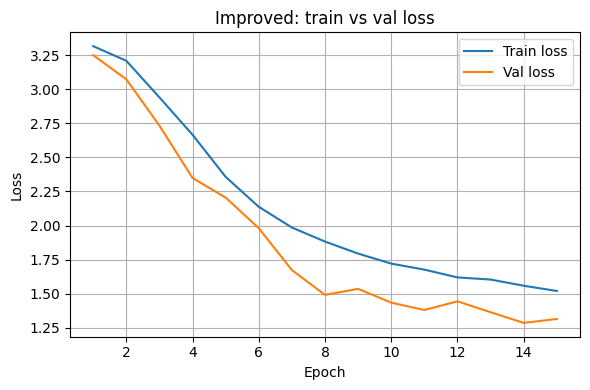

<Figure size 640x480 with 0 Axes>

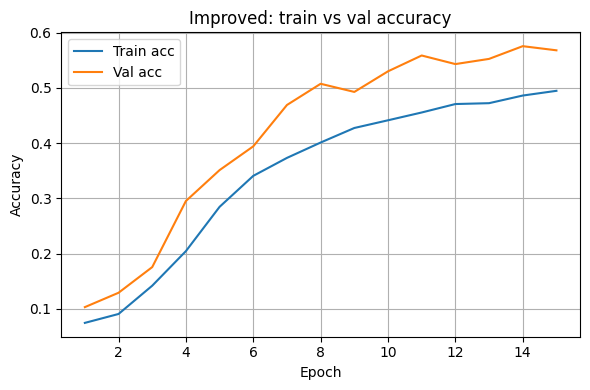

<Figure size 640x480 with 0 Axes>

In [48]:
epochs = range(1, num_epochs_improved + 1)

# loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_improved["train_loss"], label="Train loss")
plt.plot(epochs, history_improved["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Improved: train vs val loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("improved_loss_curve.png", dpi=300)

# accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_improved["train_acc"], label="Train acc")
plt.plot(epochs, history_improved["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Improved: train vs val accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("improved_acc_curve.png", dpi=300)

### Quantitative Comparison

Here we compare the two models in terms of validation perfromance. For each we report the **best validation** accuracy across epochs and the **final** validation accuracy. This would allow us to reason about perfromance as well as how stable the training process has been and how much improvement we gain from incorporating temporal information under a similar setup.

=== Validation performance summary ===


,Model,Epochs,Best val acc,Best epoch,Final val acc,Best val loss
0,Baseline (single frame),15,0.4978,15,0.4978,1.5469
1,Temporal (multi-frame),15,0.5758,14,0.5683,1.2854


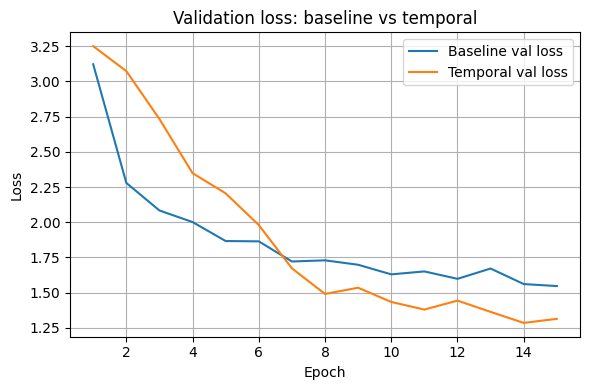

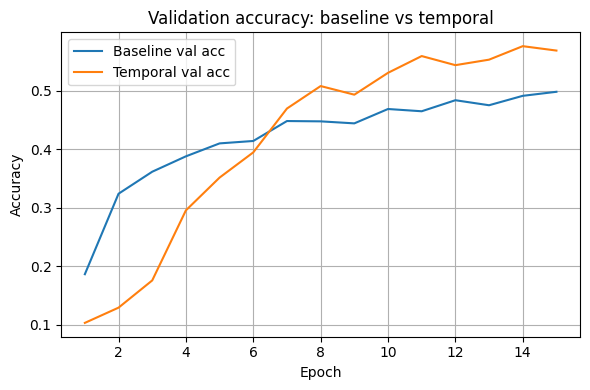

In [49]:
def summarize_history(history):
    """Return (n_epochs, best_epoch, best_val_acc, final_val_acc, best_val_loss)."""
    val_acc = np.array(history["val_acc"])
    val_loss = np.array(history["val_loss"])
    n_epochs = len(val_acc)

    best_idx = int(val_acc.argmax())
    best_epoch = best_idx + 1
    best_val_acc = float(val_acc[best_idx])
    best_val_loss = float(val_loss[best_idx])
    final_val_acc = float(val_acc[-1])

    return n_epochs, best_epoch, best_val_acc, final_val_acc, best_val_loss


base_ne, base_be, base_best_acc, base_final_acc, base_best_loss = summarize_history(history_baseline)
imp_ne,  imp_be,  imp_best_acc,  imp_final_acc,  imp_best_loss  = summarize_history(history_improved)

summary_df = pd.DataFrame([
    {
        "Model": "Baseline (single frame)",
        "Epochs": base_ne,
        "Best val acc": base_best_acc,
        "Best epoch": base_be,
        "Final val acc": base_final_acc,
        "Best val loss": base_best_loss,
    },
    {
        "Model": "Temporal (multi-frame)",
        "Epochs": imp_ne,
        "Best val acc": imp_best_acc,
        "Best epoch": imp_be,
        "Final val acc": imp_final_acc,
        "Best val loss": imp_best_loss,
    },
])

print("=== Validation performance summary ===")
display(summary_df.style.format({
    "Best val acc": "{:.4f}",
    "Final val acc": "{:.4f}",
    "Best val loss": "{:.4f}",
}))

# joint curves: loss
epochs_base = range(1, base_ne + 1)
epochs_imp  = range(1, imp_ne + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_base, history_baseline["val_loss"], label="Baseline val loss")
plt.plot(epochs_imp,  history_improved["val_loss"], label="Temporal val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation loss: baseline vs temporal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# joint curves: accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs_base, history_baseline["val_acc"], label="Baseline val acc")
plt.plot(epochs_imp,  history_improved["val_acc"], label="Temporal val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy: baseline vs temporal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Qualitative Analysis

Finally, we inspect which gesture classes are most often confused by the models. We plot confusion matrices and outline example clips where our models fail, in order to understand how much temporal infromation helps with visually similar gestures.

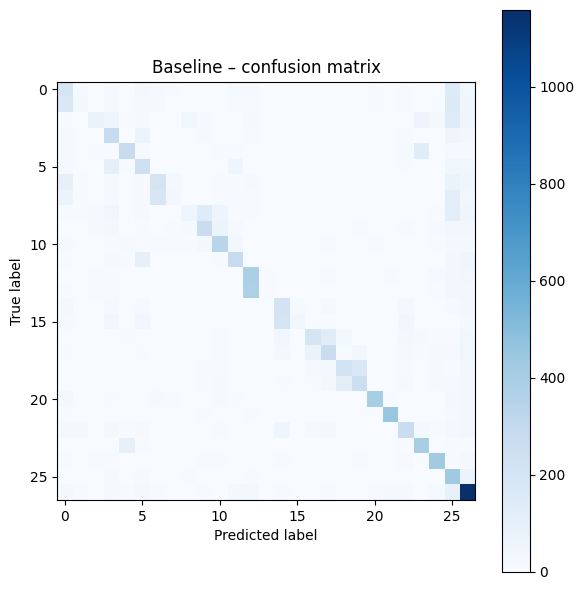

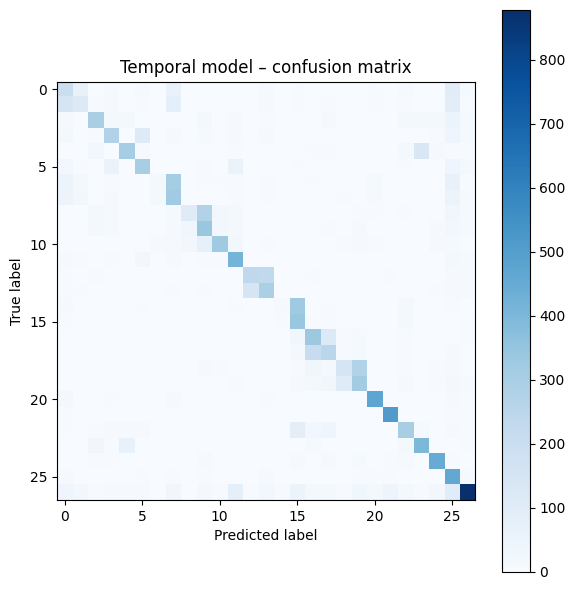

,Label,Baseline acc,Temporal acc
13,Rolling Hand Backward,0.01,0.59
1,Swiping Right,0.05,0.23
7,Sliding Two Fingers Right,0.07,0.62
15,Turning Hand Counterclockwise,0.08,0.85
8,Sliding Two Fingers Down,0.10,0.20
2,Swiping Down,0.15,0.57
16,Zooming In With Full Hand,0.37,0.63
0,Swiping Left,0.38,0.40
6,Sliding Two Fingers Left,0.40,0.03
18,Zooming In With Two Fingers,0.42,0.29


In [50]:
@torch.no_grad()
def collect_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds


# baseline
y_true_base, y_pred_base = collect_predictions(baseline_model, val_loader, device)
cm_base = confusion_matrix(y_true_base, y_pred_base, labels=range(len(gesture_labels)))

# improved
y_true_imp, y_pred_imp = collect_predictions(improved_model, val_loader_improved, device)
cm_imp = confusion_matrix(y_true_imp, y_pred_imp, labels=range(len(gesture_labels)))

def plot_confusion(cm, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()
    plt.show()

plot_confusion(cm_base, "Baseline – confusion matrix")
plot_confusion(cm_imp, "Temporal model – confusion matrix")

# per-class accuracies
def per_class_acc(cm):
    with np.errstate(divide="ignore", invalid="ignore"):
        acc = np.diag(cm) / cm.sum(axis=1)
    return acc

base_pc = per_class_acc(cm_base)
imp_pc  = per_class_acc(cm_imp)

perclass_df = pd.DataFrame({
    "Label": gesture_labels,
    "Baseline acc": base_pc,
    "Temporal acc": imp_pc,
}).sort_values("Baseline acc")

display(perclass_df.style.format({"Baseline acc": "{:.2f}", "Temporal acc": "{:.2f}"}))


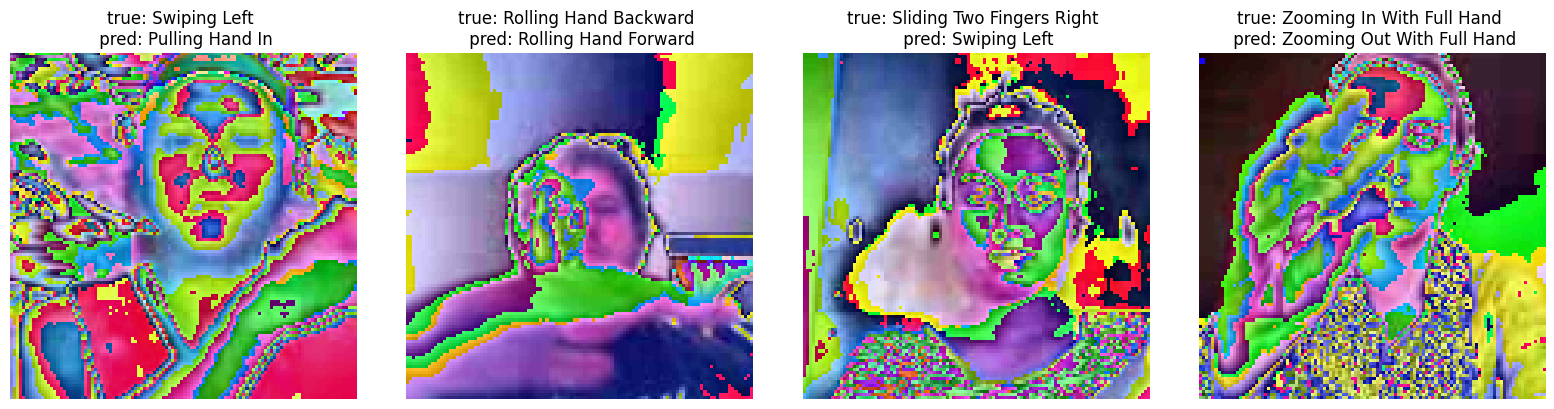

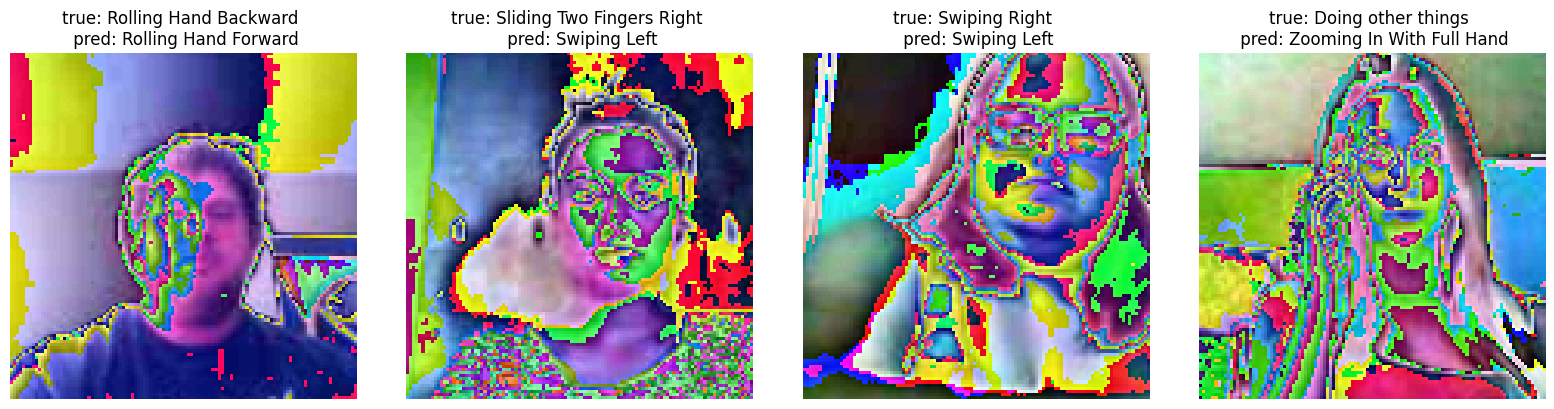

In [51]:
def show_misclassified_examples(dataset, y_true, y_pred, n_examples=4, class_idx=None):
    # pick indices where model is wrong
    wrong = np.where(y_true != y_pred)[0]
    if class_idx is not None:
        wrong = [i for i in wrong if y_true[i] == class_idx]
    wrong = wrong[:n_examples]

    fig, axes = plt.subplots(1, len(wrong), figsize=(4*len(wrong), 4))
    if len(wrong) == 1:
        axes = [axes]

    for ax, idx in zip(axes, wrong):
        x, y = dataset[idx]
        if x.ndim == 4:
            img = x[0]
        else:
            img = x
        img = to_pil_image(img)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"true: {idx_to_label[int(y_true[idx])]} \n pred: {idx_to_label[int(y_pred[idx])]}")
    plt.tight_layout()
    plt.show()

# examples for baseline
show_misclassified_examples(val_dataset, y_true_base, y_pred_base, n_examples=4)

# examples for temporal
show_misclassified_examples(val_dataset_multi, y_true_imp, y_pred_imp, n_examples=4)


### Key takeaways
- Single-frame CNNs provide a surprisingly strong baseline for Jester, but often confuse motion-dependent gestures.
- Implementing a simple temporal averaging mechanism on top of our baseline yields a clear accuracy gain without resorting to heavier models.
- Training time grows quickly with the number of frames. Reducing frames per video, shrinking batch size and freezing the backbone were the strategies we employed in order to stay within the compute budget.
- With more resources, next steps would be longer sequences, 3D convolutions or more expressive temporal heads.